In [1]:
import cv2
from matplotlib import pyplot as plt
import torch
import open3d as o3d
import numpy as np

In [2]:
midas = torch.hub.load("intel-isl/MiDaS", "MiDaS")
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.default_transform

Using cache found in C:\Users\Enrique/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\Enrique/.cache\torch\hub\facebookresearch_WSL-Images_master


Loading weights:  None


Using cache found in C:\Users\Enrique/.cache\torch\hub\intel-isl_MiDaS_master


In [3]:
#webcam_capture = cv2.VideoCapture(0)
#ret,frame = webcam_capture.read()
#cv2.imwrite('street.png',frame)
img = cv2.imread("90.png") 
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


#ret,frame1 = webcam_capture.read()
#cv2.imwrite('street.png',frame1)
img1 = cv2.imread("90.png") 
#img1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_batch = transform(img)

with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()
    
output = prediction.cpu().numpy()

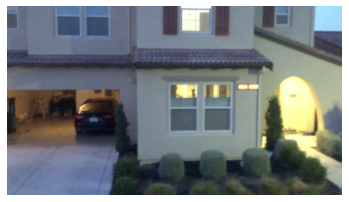

In [4]:
fig = plt.imshow(output)
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.savefig('depthmap.png', bbox_inches='tight', pad_inches = 0)

fig1 = plt.imshow(img1)
plt.axis('off')
fig1.axes.get_xaxis().set_visible(False)
fig1.axes.get_yaxis().set_visible(False)
plt.savefig('rgb.png', bbox_inches='tight', pad_inches = 0)

In [5]:
color_raw = o3d.io.read_image("C:/Users/Enrique/Desktop/SeniorProject/rgb.png")
depth_raw = o3d.io.read_image("C:/Users/Enrique/Desktop/SeniorProject/depthmap.png")

color = o3d.geometry.Image(np.array(np.asarray(color_raw)[:, :, :3]).astype('uint8'))
depth = o3d.geometry.Image(np.array(np.asarray(depth_raw)[:, :, :3]).astype('uint8'))

rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color, depth, convert_rgb_to_intensity=False)

#plt.savefig('rgbd.png', bbox_inches='tight', pad_inches = 0)

#plt.imshow(depth_raw)
#plt.show()

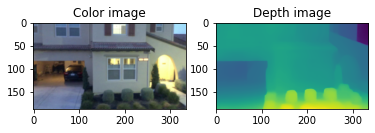

In [6]:
plt.subplot(1, 2, 1)
plt.title('Color image')
plt.imshow(rgbd_image.color)
plt.subplot(1, 2, 2)
plt.title('Depth image')
plt.imshow(rgbd_image.depth)
plt.show()

In [10]:
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image,
    o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
# Flip it, otherwise the pointcloud will be upside down
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
o3d.visualization.draw_geometries([pcd])